# Temporal Processing of Opioid Data
This code runs the DCRNN and GCGRU temporal GNNs on the synthetic dataset. Please refer to the code comments and text blocks for information about how to run the code.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!nvidia-smi

Thu May  6 18:29:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric
!pip install -q torch-geometric-temporal

     |████████████████████████████████| 2.6MB 9.2MB/s 
     |████████████████████████████████| 1.5MB 8.7MB/s 
     |████████████████████████████████| 1.0MB 8.2MB/s 
     |████████████████████████████████| 389kB 8.1MB/s 
     |████████████████████████████████| 215kB 8.5MB/s 
     |████████████████████████████████| 235kB 27.1MB/s 
     |████████████████████████████████| 2.2MB 29.3MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 25.9MB 1.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


Please note that we had particular trouble with installing Pytorch Geometric Temporal in Colab, so if you experience any issues with this, please reach out to us.

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split, DynamicGraphTemporalSignalBatch
#from torch_geometric_temporal.nn.attention.stgcn import STConv

import tqdm
import numpy as np
import pandas as pd
import networkx as nx

import pickle
from collections import Counter

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [5]:
#Setting up GPU
cuda = torch.cuda.is_available() 
if cuda:
    device = torch.device('cuda:0') # Change device here 
else:
    device = torch.device('cpu')
    
print(device)

cuda:0


## Reading in Data
The below blocks of code process the data for use in temporal networks. This is the process described in the report under the "Code Design" section. 

In [6]:
# Loads the pickle:
nx_objects = pickle.load(open('../Data/net_1000.pickle', 'rb'))

In [7]:
# Loading data:
group_to_onehot = {
    'S': (1, 0, 0, 0, 0),
    'P': (0, 1, 0, 0, 0),
    'A': (0, 0, 1, 0, 0),
    'H': (0, 0, 0, 1, 0),
    'R': (0, 0, 0, 0, 1)
}

# Gets final proportions of individuals in the graph with a given group
def get_ending_proportions(obj_list, group = 'H'):
  prop_list = []
  for i in range(len(obj_list)):
    subl = obj_list[i]
    group_last = nx.get_node_attributes(subl[-1], 'group')
    group_count = dict(Counter(group_last.values()))
    prop_list.append(group_count[group_to_onehot[group]] / subl[-1].number_of_nodes())
  return prop_list
    
end_prop = get_ending_proportions(nx_objects)
Y = end_prop # Set Y value (can be anything)

In [8]:
# Gets initial graphs:

def conv_to_undirected(edges):
  undirected_edges = list(edges)
  for e in edges:
    undirected_edges.append([e[1], e[0]])
  return undirected_edges


def get_X_times(top_tstep = 100):
  '''
  Gets the X for one network in a series
  Arguments:
  ----------
  top_tstep: integer
    - Includes all time steps from 0 to top bound
  '''

  X = []

  for i in range(0, len(nx_objects)):
    edge_indices = []
    edge_weights = []
    features = []

    #total_time = len(nx_objects[i])
    total_time = len(nx_objects[i]) if top_tstep is None else top_tstep

    for tstep in range(total_time):
      # Building edge index list:
      edge_indices.append(np.array(conv_to_undirected(nx_objects[i][tstep].edges)).T)

      # Set all edge weights to 1:
      edge_weights.append(np.array([1] * (2 * len(nx_objects[i][tstep].edges))))

      # Building features list:
      node_attr = dict(nx.get_node_attributes(nx_objects[i][tstep], 'group'))
      features.append(np.array([node_attr[i] for i in range(len(nx_objects[i][tstep].nodes))]))

    # Set targets for this signal:
    targets = [np.array(Y[i])] * total_time
    
    # Convert built lists to tensors:
    batches = [None] * total_time

    # Get signal
    sig = DynamicGraphTemporalSignalBatch(
        edge_indices = edge_indices,
        edge_weights = edge_weights,
        features = features,
        targets = targets,
        batches = batches
    )

    X.append(sig)

  return X

def train_val_split(X, val_split = 0.25):
  train_ind, val_ind = train_test_split(list(range(len(X))), test_size = val_split)
  train = [X[t] for t in train_ind]
  val = [X[v] for v in val_ind]
  return train, val

In [9]:
edges = np.array(conv_to_undirected(nx_objects[0][0].edges)).T
print(edges.shape)

(2, 1326)


In [10]:
top_tstep = 50 # Vary the time step hyperparameter HERE

full_dataset = get_X_times(top_tstep)

print('Number of samples', len(full_dataset))

train_dataset, val_dataset = train_val_split(full_dataset, val_split = 0.25)

Number of samples 1000


## Model Archictectures
In the below blocks, we define the temporal GNN archictectures that we will train and test. Please reference the report for descriptions of these models

In [11]:
# DCRNN with 1 layer
class RecurrentGCN(torch.nn.Module):
  def __init__(self, node_features):
    super(RecurrentGCN, self).__init__()
    self.recurrent = DCRNN(node_features, 32, 8)
    self.linear = torch.nn.Linear(32, 1)

  def forward(self, x, edge_index, edge_weight):
    h = self.recurrent(x, edge_index, edge_weight)
    h = F.relu(h)
    h = self.linear(h)
    return h

In [12]:
# DCRNN with 2 layer
class RecurrentGCN2(torch.nn.Module):
  def __init__(self, node_features):
    super(RecurrentGCN2, self).__init__()
    self.recurrent1 = DCRNN(node_features, 32, 8)
    self.recurrent2 = DCRNN(32, 32, 1)
    self.linear = torch.nn.Linear(32, 1)

  def forward(self, x, edge_index, edge_weight):
    h = self.recurrent1(x, edge_index, edge_weight)
    h = F.relu(h)
    h = self.recurrent2(h, edge_index, edge_weight)
    h = self.linear(h)
    return h

In [13]:
# DCRNN with 3 layer
class RecurrentGCN3(torch.nn.Module):
  def __init__(self, node_features):
    super(RecurrentGCN3, self).__init__()
    self.recurrent1 = DCRNN(node_features, 32, 8)
    self.recurrent2 = DCRNN(32, 32, 1)
    self.recurrent3 = DCRNN(32, 32, 1)
    self.linear = torch.nn.Linear(32, 1)

  def forward(self, x, edge_index, edge_weight):
    h = self.recurrent1(x, edge_index, edge_weight)
    h = F.relu(h)
    h = self.recurrent2(h, edge_index, edge_weight)
    h = F.relu(h)
    h = self.recurrent3(h, edge_index, edge_weight)
    h = F.relu(h)
    h = self.linear(h)
    return h

In [14]:
from torch_geometric_temporal.nn.recurrent import GConvGRU

# GCGRU with 1 layer
class GCGRU(torch.nn.Module):
  def __init__(self, node_features):
    super(GCGRU, self).__init__()
    self.recurrent = GConvGRU(node_features, 32, 8)
    self.linear = torch.nn.Linear(32, 1)

  def forward(self, x, edge_index, edge_weight):
    h = self.recurrent(x, edge_index, edge_weight)
    h = F.relu(h)
    h = self.linear(h)
    return h

In [15]:
# GCGRU with 2 layers
class GCGRU2(torch.nn.Module):
  def __init__(self, node_features):
    super(GCGRU2, self).__init__()
    self.recurrent1 = GConvGRU(node_features, 32, 8)
    self.recurrent2 = GConvGRU(32, 32, 1)
    self.linear = torch.nn.Linear(32, 1)

  def forward(self, x, edge_index, edge_weight):
    h = self.recurrent1(x, edge_index, edge_weight)
    h = F.relu(h)
    h = self.recurrent2(h, edge_index, edge_weight)
    h = F.relu(h)
    h = self.linear(h)
    return h

In [16]:
# GCGRU with 3 layers
class GCGRU3(torch.nn.Module):
  def __init__(self, node_features):
    super(GCGRU3, self).__init__()
    self.recurrent1 = GConvGRU(node_features, 32, 8)
    self.recurrent2 = GConvGRU(32, 32, 1)
    self.recurrent3 = GConvGRU(32, 32, 1)
    self.linear = torch.nn.Linear(32, 1)

  def forward(self, x, edge_index, edge_weight):
    h = self.recurrent1(x, edge_index, edge_weight)
    h = F.relu(h)
    h = self.recurrent2(h, edge_index, edge_weight)
    h = F.relu(h)
    h = self.recurrent3(h, edge_index, edge_weight)
    h = F.relu(h)
    h = self.linear(h)
    return h

## Setting up the Models - Prepare to Train
The code in the below block sets up the model that will be trained in a later block.

### Varying the Architecture
To change the architecture upon which you train the model, change the first line in the below block to run on the desired architecture declared in the classes above.

In [17]:
model = RecurrentGCN(node_features = 5).to(device) # Change this line to run a different model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

def MSEloss(y_hat, y):
  '''Computes mean squared error loss on tensors'''
  return torch.mean((y_hat-y.to(device))**2)

def test_eval(test_data):
  '''Evaluates the testing set based on current state of model
  Returns the r2 value of the testing data evaluated on the model
  '''
  preds = []
  gt = []
  for test_sig in test_data:
    y_hat = 0
    y = 0
    for time, snapshot in enumerate(test_sig):
      y_hat = model(snapshot.x.to(device), snapshot.edge_index.to(device), snapshot.edge_attr.to(device))
      y = snapshot.y

    preds.append(y_hat.cpu().detach().numpy().reshape(-1, 1)[-1])
    gt.append(y.detach().numpy())

  return r2_score(gt, preds)

def train_one_batch(train_signal):
  '''
  Trains one epoch of the training procedure for one signal
  Args:
  -----
  train_signal: Signal object
    - Signal object from Pytorch Geometric Temporal
  '''
  cost = 0
  y_hat = 0
  y = 0
  # Need to run the entire algorithm, compute prediction at end
  for time, snapshot in enumerate(train_signal):
    y_hat = model(snapshot.x.to(device), snapshot.edge_index.to(device), snapshot.edge_attr.to(device))
    y = snapshot.y.to(device)

  # Compute cost once at end (many-to-one task):
  cost = MSEloss(y_hat, y)
  cost.backward()

  # Optimizer steps:
  optimizer.step()
  optimizer.zero_grad()
  return cost

def train(train_data, epochs = 100):
  '''
  Trains the model
  - Function currently does not perform batching, goes one-by-one for signals

  train_data: list of Data Signals
    - One signal for each sample
  '''

  train_loss = []
  train_acc = []
  test_acc = []

  for epoch in tqdm.tqdm(range(epochs)):
    cost_total = 0
    for train_sig in train_data:
      cost = train_one_batch(train_sig)
      cost_total = cost_total + cost

    cost_total /= len(train_data) # Gets average cost over all samples
    train_loss.append(cost_total)

    te_acc = test_eval(val_dataset) # Get accuracy after the epoch
    tr_acc = test_eval(train_dataset)

    train_acc.append(tr_acc)
    test_acc.append(te_acc)

  return train_loss, train_acc, test_acc


## Training the model
The below block actually trains the model that you declared in the above block.


100%|██████████| 10/10 [2:16:15<00:00, 817.56s/it]


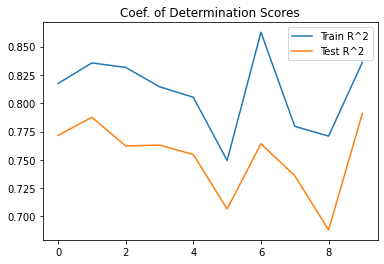

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Performs the actual training
tr_loss, tr_acc, te_acc = train(train_dataset, epochs = 10)
x = list(range(len(tr_loss)))

# Saves results to CSV file in local directory:
results = pd.DataFrame({'Train_Acc':tr_acc, 'Test_Acc':te_acc, 'Train_Loss':tr_loss})
results['model'] = ['RecurrentGCN 1 Layer'] + [None] * (len(tr_loss) - 1)
results.to_csv('RecGCN_1_Layer.csv', index = False)

# Plot the accuracy curves
plt.plot(x, tr_acc, label = 'Train R^2')
plt.plot(x, te_acc, label = 'Test R^2')
plt.title('Coef. of Determination Scores')
plt.legend()
plt.show()

In [20]:
model = GCGRU(node_features = 5).to(device) # Change this line to run a different model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

def MSEloss(y_hat, y):
  '''Computes mean squared error loss on tensors'''
  return torch.mean((y_hat-y.to(device))**2)

def test_eval(test_data):
  '''Evaluates the testing set based on current state of model
  Returns the r2 value of the testing data evaluated on the model
  '''
  preds = []
  gt = []
  for test_sig in test_data:
    y_hat = 0
    y = 0
    for time, snapshot in enumerate(test_sig):
      y_hat = model(snapshot.x.to(device), snapshot.edge_index.to(device), snapshot.edge_attr.to(device))
      y = snapshot.y

    preds.append(y_hat.cpu().detach().numpy().reshape(-1, 1)[-1])
    gt.append(y.detach().numpy())

  return r2_score(gt, preds)

def train_one_batch(train_signal):
  '''
  Trains one epoch of the training procedure for one signal
  Args:
  -----
  train_signal: Signal object
    - Signal object from Pytorch Geometric Temporal
  '''
  cost = 0
  y_hat = 0
  y = 0
  # Need to run the entire algorithm, compute prediction at end
  for time, snapshot in enumerate(train_signal):
    y_hat = model(snapshot.x.to(device), snapshot.edge_index.to(device), snapshot.edge_attr.to(device))
    y = snapshot.y.to(device)

  # Compute cost once at end (many-to-one task):
  cost = MSEloss(y_hat, y)
  cost.backward()

  # Optimizer steps:
  optimizer.step()
  optimizer.zero_grad()
  return cost

def train(train_data, epochs = 100):
  '''
  Trains the model
  - Function currently does not perform batching, goes one-by-one for signals

  train_data: list of Data Signals
    - One signal for each sample
  '''

  train_loss = []
  train_acc = []
  test_acc = []

  for epoch in tqdm.tqdm(range(epochs)):
    cost_total = 0
    for train_sig in train_data:
      cost = train_one_batch(train_sig)
      cost_total = cost_total + cost

    cost_total /= len(train_data) # Gets average cost over all samples
    train_loss.append(cost_total)

    te_acc = test_eval(val_dataset) # Get accuracy after the epoch
    tr_acc = test_eval(train_dataset)

    train_acc.append(tr_acc)
    test_acc.append(te_acc)

  return train_loss, train_acc, test_acc



100%|██████████| 10/10 [2:54:15<00:00, 1045.55s/it]


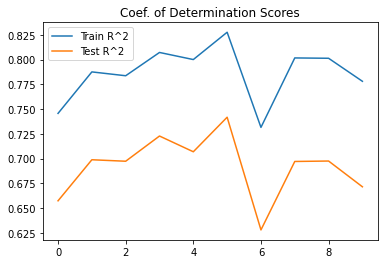

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Performs the actual training
tr_loss, tr_acc, te_acc = train(train_dataset, epochs = 10)
x = list(range(len(tr_loss)))

# Saves results to CSV file in local directory:
results = pd.DataFrame({'Train_Acc':tr_acc, 'Test_Acc':te_acc, 'Train_Loss':tr_loss})
results['model'] = ['RecurrentGCN 1 Layer'] + [None] * (len(tr_loss) - 1)
results.to_csv('GCGRU_1_Layer.csv', index = False)

# Plot the accuracy curves
plt.plot(x, tr_acc, label = 'Train R^2')
plt.plot(x, te_acc, label = 'Test R^2')
plt.title('Coef. of Determination Scores')
plt.legend()
plt.show()